In [1]:
import sys
sys.path.append('/u/ajagadish/ermi/categorisation/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import math
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

## visualising generated functions

In [33]:
df = pd.read_csv(f'{SYS_PATH}/categorisation/data/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv')
num_tasks = 200
random_tasks = np.random.randint(low=df['task_id'].min(), high=df['task_id'].max(), size=num_tasks)
# keep only first 100 tasks
df = df[df['task_id'].isin(random_tasks)]
df['input'] = df['input'].apply(lambda x: eval(x)[0])
# devide input by max value for each task
df['input'] = df.apply(lambda x: x['input']/(df[df['task_id']==x['task_id']]['input'].max()+0.0001), axis=1)
df['target'] = df.apply(lambda x: x['target']/(df[df['task_id']==x['task_id']]['target'].max()+0.0001), axis=1)

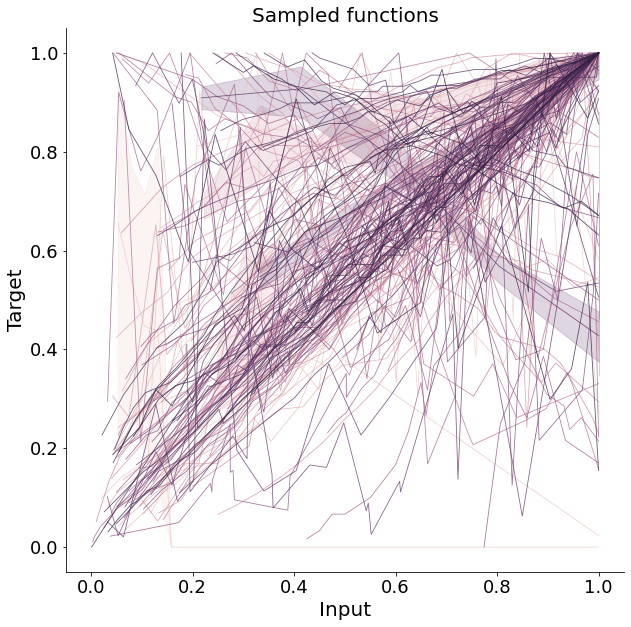

In [34]:
# plot scatter plot of input vs target colored by task
plt.figure(figsize=(10,10))
sns.lineplot(x='input', y='target', hue='task_id', data=df, legend=False, alpha=0.8, linewidth=0.8)
plt.xlabel('Input', fontsize=FONTSIZE)
plt.ylabel('Target', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()


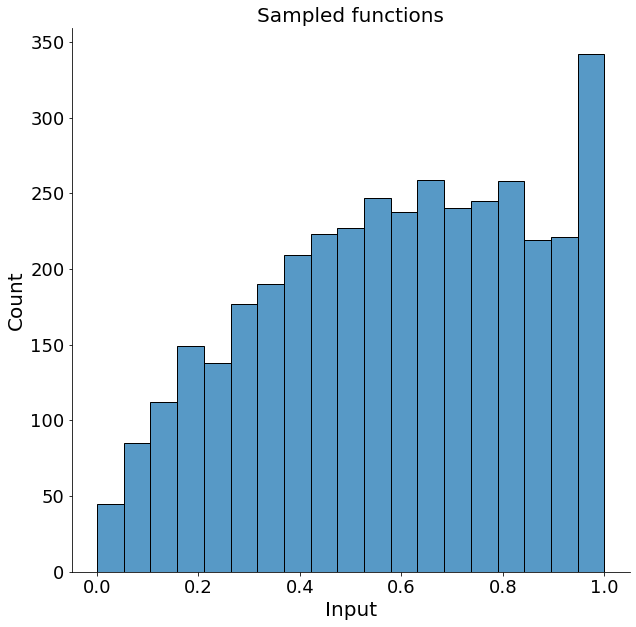

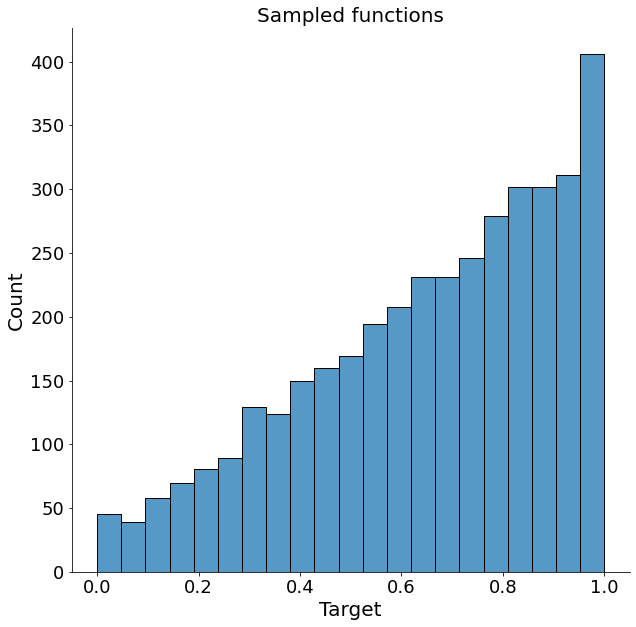

In [39]:
# plot scatter plot of input vs target colored by task
plt.figure(figsize=(10,10))
sns.histplot(data=df, x='input')
plt.xlabel('Input', fontsize=FONTSIZE)
plt.ylabel('Count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()

plt.figure(figsize=(10,10))
sns.histplot(data=df, x='target')
plt.xlabel('Target', fontsize=FONTSIZE)
plt.ylabel('Count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()


## testing prompt

In [71]:
def synthesize_functionlearning_problems(model, version, num_dim=1, num_tasks=100):

    instructions = {}
    features_to_text = {1: 'a real-world feature is mapped to its corresponding target, with both feature and target taking on continuous values', 2: 'two real-world features are mapped to their corresponding target, with features and target taking on continuous values'}
    format_to_text = {1: '- feature name, target name', 2: '- feature name 1, feature name 2, target name'}
    synthesize_feature_names_prompt_v0  = f" I am a psychologist who wants to run a function learning experiment. "\
                 f"In a function learning experiment, {features_to_text[num_dim]}."\
                 f" Please generate names for features and its corresponding target for {str(num_tasks)} different function learning experiments: \n"\
                 f"{format_to_text[num_dim]} \n"  
    
    instructions['claude'] = {}
    instructions['claude']['v0'] = synthesize_feature_names_prompt_v0

    
    return instructions[model][version]

In [76]:
print(synthesize_functionlearning_problems(model='claude', version='v0', num_dim=1))

 I am a psychologist who wants to run a function learning experiment. In a function learning experiment, a real-world feature is mapped to its corresponding target, with both feature and target taking on continuous values. Please generate names for features and its corresponding target for 100 different function learning experiments: 
- feature name, target name 



In [77]:
def synthesize_decisionmaking_problems(model, version, num_dim=2, num_tasks=100):

    instructions = {}
    features_to_text = {1: 'a real-world feature is mapped to its corresponding target, with both feature and target taking on continuous values', 2: 'two real-world features are mapped to their corresponding target, with features and target taking on continuous values'}
    format_to_text = {1: '- feature name, target name', 2: '- feature name 1, feature name 2, target name'}
    synthesize_feature_names_prompt_v0  = f" I am a psychologist who wants to run a decision-making experiment. "\
                 f"In a decision-making experiment, {features_to_text[num_dim]}."\
                 f" Please generate names for features and its corresponding target for {str(num_tasks)} different decision-making experiments: \n"\
                 f"{format_to_text[num_dim]} \n"  
    
    instructions['claude'] = {}
    instructions['claude']['v0'] = synthesize_feature_names_prompt_v0

    
    return instructions[model][version]

In [79]:
print(synthesize_decisionmaking_problems(model='claude', version='v0', num_dim=2))

 I am a psychologist who wants to run a decision-making experiment. In a decision-making experiment, two real-world features are mapped to their corresponding target, with features and target taking on continuous values. Please generate names for features and its corresponding target for 100 different decision-making experiments: 
- feature name 1, feature name 2, target name 



In [11]:
def generate_data_functionlearning(model, version, num_dim=3, num_data=20, features=None, categories=None):

    instructions = {}
    
    # num_to_text = {2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight'}
    # def featurenames_to_text(features,targets, num_dim):
    #     if num_dim==3:
    #         return f'{features[0]}, {features[1]}, and {features[2]}', {targets}
    #     elif num_dim==4:
    #         return f'{features[0]}, {features[1]}, {features[2]}, {features[3]}'
    #     elif num_dim==6:
    #         return f'{features[0]}, {features[1]}, {features[2]}, {features[3]}, {features[4]}, and {features[5]}'
    instructions['claude'] = {}
    feature, target = 'Game difficulty', 'Game engagement'
    generate_data_prompt_v1 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of feature and target pairs."\
                         f" The feature and target in this case are {feature.lower()} and {target.lower()} respectively."\
                         f" The feature can take only numerical values and must be continuous."\
                         f" {target.capitalize()} should be predictable from the feature and must also take on continuous values."\
                          " \n\n"\
                        f" Please generate a list of {str(num_data)} feature-target pairs"\
                         " sequentially using the following template for each row: \n"\
                        f" 1: {feature.lower()} value, {target.lower()} value \n"\
                        f"Please do not skip any row; values taken by features and target do not need to be ordered."
    
    # instructions['claude']['v0'] = generate_data_prompt_v0
    instructions['claude']['v1'] = generate_data_prompt_v1
    # print(instructions)
    return instructions[model][version]

In [65]:
def generate_data_functionlearning_problems(model, version, num_data=20, features=None, target=None):

    instructions = {}
    instructions['claude'] = {}
    num_dim=len(features)
    # feature, target = 'Game difficulty', 'Game engagement'
#     generate_data_prompt_v0 = f" I am a psychologist who wants to run a function learning experiment."\
#                           " For a function learning experiment, I need a list of feature and target pairs."\
#                          f" The feature and target in this case are {features.lower()} and {target.lower()} respectively."\
#                          f" {features.capitalize()} can take only numerical values and must be continuous."\
#                          f" {target.capitalize()} should be predictable from the {features.lower()} and must also take on continuous values."\
#                           " \n\n"\
#                         f" Please generate a list of {str(num_data)} feature-target pairs"\
#                          " sequentially using the following template for each row: \n"\
#                         f" 1: {features.lower()} value, {target.lower()} value \n"\
#                         f"Please do not skip any row; values taken by {features.lower()} and {target.lower()} do not need to be ordered."
#.    instructions['claude']['v0'] = generate_data_prompt_v0
    
#     generate_data_prompt_v1 = f" I am a psychologist who wants to run a function learning experiment."\
#                           " For a function learning experiment, I need a list of feature and target pairs."\
#                          f" The feature and target in this case are {features.lower()} and {target.lower()} respectively."\
#                          f" The feature can take only numerical values and must be continuous."\
#                          f" {target.capitalize()} should be predictable from the feature and must also take on continuous values."\
#                           " \n\n"\
#                         f" Please generate a list of {str(num_data)} feature-target pairs"\
#                          " sequentially using the following template for each row: \n"\
#                         f" 1: {features.lower()} value, {target.lower()} value \n"\
#                         f"Please do not skip any row; values taken by features and target do not need to be ordered."
    # instructions['claude']['v1'] = generate_data_prompt_v1
    
    def featurenames_to_text(features, num_dim):
        if num_dim==1:
            return f'feature in this case is {features[0].lower()}', 'The feature takes', '- feature value, target value'
        elif num_dim==2:
            return f'features in this case are {features[0].lower()} and {features[1].lower()}', 'These features take', '- feature value 1, feature value 2, target value'
        
    feature_text, style, template = featurenames_to_text(features, num_dim)
        
    generate_data_prompt_v2 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of features with their corresponding target."\
                         f" The {feature_text}."\
                         f" {style} on only numerical values and must be continuous."\
                         f" The target, {target.lower()}, should be predictable from the feature values and must also take on continuous values."\
                          " \n\n"\
                         f" Please generate a list of {str(num_data)} feature-target pairs"\
                          " sequentially using the following template for each row: \n"\
                         f" {template} \n"\
                         f" Please do not skip any row; values taken by features and targets do not need to be ordered."
    
    
   
    instructions['claude']['v2'] = generate_data_prompt_v2
    
    return instructions[model][version]

In [68]:
def generate_data_functionlearning_problems(model, version, num_data=20, num_dim=1, features=None, target=None):

    instructions = {}
    instructions['claude'] = {}
    # feature, target = 'Game difficulty', 'Game engagement'
    generate_data_prompt_v0 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of feature and target pairs."\
                         f" The feature and target in this case are {features[0].lower()} and {target.lower()} respectively."\
                         f" {features[0].capitalize()} can take only numerical values and must be continuous."\
                         f" {target.capitalize()} should be predictable from the {features[0].lower()} and must also take on continuous values."\
                          " \n\n"\
                        f" Please generate a list of {str(num_data)} feature-target pairs"\
                         " sequentially using the following template for each row: \n"\
                        f" 1: {features[0].lower()} value, {target.lower()} value \n"\
                        f"Please do not skip any row; values taken by {features[0].lower()} and {target.lower()} do not need to be ordered."
    
    generate_data_prompt_v1 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of feature and target pairs."\
                         f" The feature and target in this case are {features[0].lower()} and {target.lower()} respectively."\
                         f" The feature can take only numerical values and must be continuous."\
                         f" {target.capitalize()} should be predictable from the feature and must also take on continuous values."\
                          " \n\n"\
                        f" Please generate a list of {str(num_data)} feature-target pairs"\
                         " sequentially using the following template for each row: \n"\
                        f" 1: {features[0].lower()} value, {target.lower()} value \n"\
                        f"Please do not skip any row; values taken by features and target do not need to be ordered."
    
    def featurenames_to_text(features, num_dim):
        if num_dim==1:
            return f'feature in this case is {features[0].lower()}', 'The feature takes', '- feature value, target value'
        elif num_dim==2:
            return f'features in this case are {features[0].lower()} and {features[1].lower()}', 'These features take', '- feature value 1, feature value 2, target value'
        
    feature_text, style, template = featurenames_to_text(features, num_dim)
    generate_data_prompt_v2 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of features with their corresponding target."\
                         f" The {feature_text}."\
                         f" {style} on only numerical values and must be continuous."\
                         f" The target, {target.lower()}, should be predictable from the feature values and must also take on continuous values."\
                          " \n\n"\
                         f" Please generate a list of {str(num_data)} feature-target pairs"\
                          " sequentially using the following template for each row: \n"\
                         f" {template} \n"\
                         f" Please do not skip any row; values taken by features and targets do not need to be ordered."
    
    instructions['claude']['v0'] = generate_data_prompt_v0
    instructions['claude']['v1'] = generate_data_prompt_v1
    instructions['claude']['v2'] = generate_data_prompt_v2
    
    return instructions[model][version]

In [69]:
print(generate_data_functionlearning_problems(model='claude', version='v2', features=['Height'], target='Weight'))

 I am a psychologist who wants to run a function learning experiment. For a function learning experiment, I need a list of features with their corresponding target. The feature in this case is height. The feature takes on only numerical values and must be continuous. The target, weight, should be predictable from the feature values and must also take on continuous values. 

 Please generate a list of 20 feature-target pairs sequentially using the following template for each row: 
 - feature value, target value 
 Please do not skip any row; values taken by features and targets do not need to be ordered.


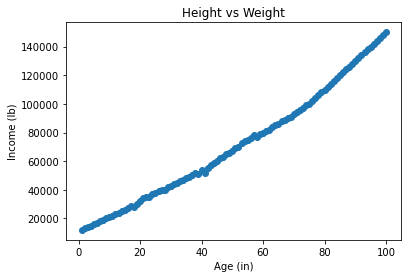

In [53]:
import matplotlib.pyplot as plt

heights = [32, 41, 28, 50, 23, 19, 55, 47, 29, 36, 62, 24, 18, 39, 45, 60, 33, 26, 42, 38, 48, 27, 58, 54, 49, 20, 53, 46, 43, 64, 21, 51, 63, 40, 30, 37, 59, 35, 56, 31, 44, 61, 25, 17, 52, 34, 65, 22, 16, 57, 15, 66, 67, 68, 69, 70, 14, 71, 13, 72, 12, 73, 11, 10, 74, 9, 75, 8, 76, 7, 77, 6, 78, 5, 79, 4, 80, 3, 81, 2, 82, 1, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100] 

weights = [45000, 52000, 40000, 67000, 35000, 30000, 75000, 63000, 42000, 49000, 82000, 37000, 28000, 51000, 60000, 80000, 46000, 39000, 55000, 52000, 65000, 40000, 77000, 74000, 66000, 32000, 73000, 62000, 57000, 85000, 34000, 69000, 84000, 54000, 43000, 50000, 79000, 48000, 76000, 44000, 59000, 81000, 38000, 29000, 70000, 47000, 86000, 35000, 27000, 78000, 26000, 88000, 89000, 90000, 91000, 93000, 25000, 94000, 24000, 96000, 23000, 97000, 22000, 21000, 99000, 20000, 100000, 19000, 102000, 18000, 104000, 17000, 106000, 16000, 108000, 15000, 110000, 14000, 112000, 13000, 114000, 12000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000]

plt.scatter(heights, weights)
plt.xlabel('Age (in)')
plt.ylabel('Income (lb)')
plt.title('Height vs Weight')
plt.show()

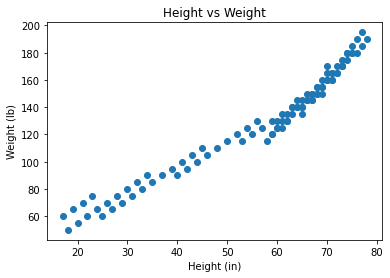

In [54]:
import matplotlib.pyplot as plt

heights = [65, 72, 68, 74, 70, 66, 62, 60, 71, 69, 67, 73, 75, 61, 64, 63, 59, 58, 76, 70, 68, 72, 74, 77, 65, 73, 71, 69, 67, 75, 62, 60, 64, 66, 70, 68, 61, 59, 63, 65, 69, 67, 71, 73, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 77, 75, 73, 71, 69, 67, 65, 63, 61, 59, 57, 55, 53, 56, 54, 52, 50, 48, 46, 44, 42, 40, 45, 43, 41, 39, 37, 35, 33, 31, 29, 27, 25, 34, 32, 30, 28, 26, 24, 22, 20, 18, 23, 21, 19, 17]

weights = [140, 165, 155, 180, 170, 150, 135, 130, 160, 160, 145, 175, 185, 125, 145, 140, 120, 115, 190, 165, 150, 170, 180, 195, 135, 170, 165, 155, 150, 180, 130, 125, 140, 145, 160, 155, 130, 120, 135, 140, 150, 145, 165, 170, 125, 130, 140, 145, 150, 160, 165, 175, 180, 190, 185, 180, 170, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 130, 125, 120, 115, 110, 105, 100, 95, 90, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60, 90, 85, 80, 75, 70, 65, 60, 55, 50, 75, 70, 65, 60]

plt.scatter(heights, weights)
plt.xlabel('Height (in)')
plt.ylabel('Weight (lb)')
plt.title('Height vs Weight')
plt.show()

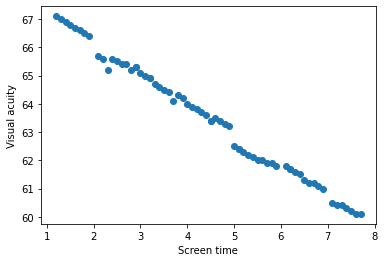

In [70]:
import matplotlib.pyplot as plt

x = [2.3, 5.1, 3.7, 4.9, 6.2, 1.5, 3.2, 4.6, 5.4, 7.1, 2.9, 6.7, 1.8, 5.8, 3.4, 2.1, 4.2, 6.3, 5.2, 3.1, 7.5, 4.3, 2.7, 6.1, 3.9, 5.6, 1.2, 4.7, 6.9, 2.5, 3.3, 5.0, 7.3, 1.6, 4.1, 2.8, 6.5, 3.5, 4.4, 5.7, 1.9, 2.4, 6.8, 3.8, 4.8, 7.7, 5.9, 1.3, 2.2, 4.5, 6.4, 3.0, 5.3, 7.4, 1.7, 4.0, 2.6, 6.2, 5.5, 3.6, 7.2, 1.4, 4.5, 2.9, 6.6, 5.1, 3.2, 7.6]

y = [65.2, 62.4, 64.1, 63.2, 61.7, 66.8, 64.9, 63.5, 62.1, 60.5, 65.3, 61.2, 66.5, 61.9, 64.6, 65.7, 63.8, 61.6, 62.3, 65.0, 60.2, 63.7, 65.4, 61.8, 64.2, 62.0, 67.1, 63.4, 61.0, 65.5, 64.7, 62.5, 60.4, 66.7, 63.9, 65.2, 61.3, 64.5, 63.6, 61.9, 66.4, 65.6, 61.1, 64.3, 63.3, 60.1, 61.8, 67.0, 65.6, 63.4, 61.5, 65.1, 62.2, 60.3, 66.6, 64.0, 65.4, 61.7, 62.0, 64.4, 60.4, 66.9, 63.4, 65.3, 61.2, 62.4, 64.9, 60.1]
plt.scatter(x, y)
plt.xlabel('Screen time')
plt.ylabel('Visual acuity')
plt.title('')
plt.show()

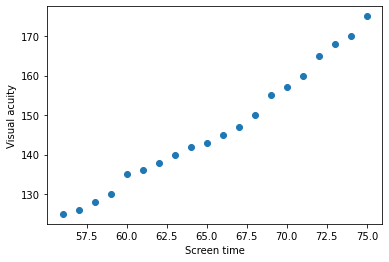

In [67]:
import matplotlib.pyplot as plt

x = [68, 72, 74, 63, 60, 66, 69, 71, 73, 75, 62, 61, 65, 70, 64, 67, 59, 58, 56, 57]
y = [150, 165, 170, 140, 135, 145, 155, 160, 168, 175, 138, 136, 143, 157, 142, 147, 130, 128, 125, 126]

plt.scatter(x, y)
plt.xlabel('Screen time')
plt.ylabel('Visual acuity')
plt.title('')
plt.show()

In [66]:
len(y)

96

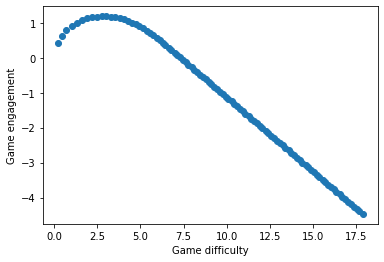

In [69]:
import matplotlib.pyplot as plt

x = [0.23, 0.47, 0.71, 1.05, 1.32, 1.63, 1.89, 2.21, 2.47, 2.77, 3.02, 3.31, 3.54, 3.82, 4.03, 4.29, 4.49, 4.74, 4.93, 5.17, 5.35, 5.58, 5.74, 5.96, 6.11, 6.31, 6.45, 6.65, 6.79, 6.98, 7.12, 7.31, 7.45, 7.64, 7.78, 7.97, 8.11, 8.30, 8.44, 8.63, 8.77, 8.96, 9.10, 9.29, 9.43, 9.62, 9.76, 9.95, 10.09, 10.28, 10.42, 10.61, 10.75, 10.94, 11.08, 11.27, 11.41, 11.60, 11.74, 11.93, 12.07, 12.26, 12.40, 12.59, 12.73, 12.92, 13.06, 13.25, 13.39, 13.58, 13.72, 13.91, 14.05, 14.24, 14.38, 14.57, 14.71, 14.90, 15.04, 15.23, 15.37, 15.56, 15.70, 15.89, 16.03, 16.22, 16.36, 16.55, 16.69, 16.88, 17.02, 17.21, 17.35, 17.54, 17.68, 17.87,]

y = [0.41, 0.62, 0.79, 0.91, 1.01, 1.08, 1.13, 1.16, 1.18, 1.19, 1.19, 1.18, 1.16, 1.13, 1.10, 1.06, 1.01, 0.96, 0.90, 0.84, 0.78, 0.71, 0.64, 0.57, 0.50, 0.43, 0.36, 0.29, 0.22, 0.15, 0.08, 0.01, -0.06, -0.13, -0.20, -0.27, -0.34, -0.41, -0.48, -0.55, -0.62, -0.69, -0.76, -0.83, -0.90, -0.97, -1.04, -1.11, -1.18, -1.25, -1.32, -1.39, -1.46, -1.53, -1.60, -1.67, -1.74, -1.81, -1.88, -1.95, -2.02, -2.09, -2.16, -2.23, -2.30, -2.37, -2.44, -2.51, -2.58, -2.65, -2.72, -2.79, -2.86, -2.93, -3.00, -3.07, -3.14, -3.21, -3.28, -3.35, -3.42, -3.49, -3.56, -3.63, -3.70, -3.77, -3.84, -3.91, -3.98, -4.05, -4.12, -4.19, -4.26, -4.33, -4.40, -4.47] 
plt.scatter(x, y)
plt.xlabel('Game difficulty')
plt.ylabel('Game engagement')
plt.show()

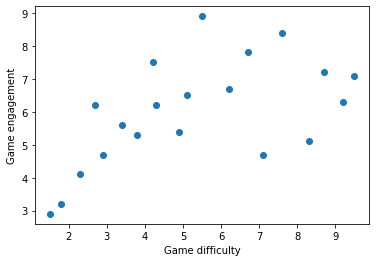

In [8]:
import matplotlib.pyplot as plt

x = [4.2, 8.3, 2.7, 5.5, 7.1, 3.4, 9.2, 1.8, 6.7, 5.1, 4.9, 8.7, 2.3, 7.6, 3.8, 1.5, 6.2, 9.5, 4.3, 2.9]
y = [7.5, 5.1, 6.2, 8.9, 4.7, 5.6, 6.3, 3.2, 7.8, 6.5, 5.4, 7.2, 4.1, 8.4, 5.3, 2.9, 6.7, 7.1, 6.2, 4.7]


plt.scatter(x, y)
plt.xlabel('Game difficulty')
plt.ylabel('Game engagement')
plt.show()

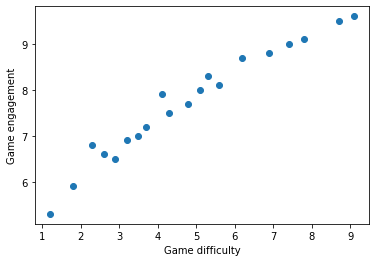

In [13]:
import matplotlib.pyplot as plt

x = [2.3, 4.1, 3.7, 5.6, 6.2, 1.8, 7.4, 2.9, 5.3, 3.5, 4.8, 8.7, 1.2, 6.9, 9.1, 7.8, 3.2, 2.6, 4.3, 5.1]
y = [6.8, 7.9, 7.2, 8.1, 8.7, 5.9, 9.0, 6.5, 8.3, 7.0, 7.7, 9.5, 5.3, 8.8, 9.6, 9.1, 6.9, 6.6, 7.5, 8.0]

plt.scatter(x, y)
plt.xlabel('Game difficulty')
plt.ylabel('Game engagement')
plt.show()

In [62]:
def generate_data_decisionmaking_problems(model, version, num_data=20, features=None, target=None):

    instructions = {}
    instructions['claude'] = {}
    num_dim = len(features)
    
    def featurenames_to_text(features, num_dim):
        if num_dim==1:
            return f'feature in this case is {features[0].lower()}', 'The feature takes', '- feature value, target value'
        elif num_dim==2:
            return f'features in this case are {features[0].lower()} and {features[1].lower()}', 'These features take', '- feature value 1, feature value 2, target value'
        
    feature_text, style, template = featurenames_to_text(features, num_dim)
    
    generate_data_prompt_v0 = f" I am a psychologist who wants to run a decision-making experiment."\
                          " For a decision-making experiment, I need a list of features with their corresponding target."\
                         f" The {feature_text}."\
                         f" {style} on only numerical values and must be continuous."\
                         f" The target, {target.lower()}, should be predictable from the feature values and must also take on continuous values."\
                          " \n\n"\
                         f" Please generate a list of {str(num_data)} feature-target pairs"\
                          " sequentially using the following template for each row: \n"\
                         f" {template} \n"\
                         f"  Please do not skip any row; values taken by features and targets do not need to be ordered."
    
    instructions['claude']['v0'] = generate_data_prompt_v0
    
    return instructions[model][version]

In [63]:
features= ["Material Cost", "Production Time"]
target = "Product Price"

In [64]:
print(generate_data_decisionmaking_problems(model='claude', version='v0', features=features, target=target))

 I am a psychologist who wants to run a decision-making experiment. For a decision-making experiment, I need a list of features with their corresponding target. The features in this case are material cost and production time. These features take on only numerical values and must be continuous. The target, product price, should be predictable from the feature values and must also take on continuous values. 

 Please generate a list of 20 feature-target pairs sequentially using the following template for each row: 
 - feature value 1, feature value 2, target value 
  Please do not skip any row; values taken by features and targets do not need to be ordered.


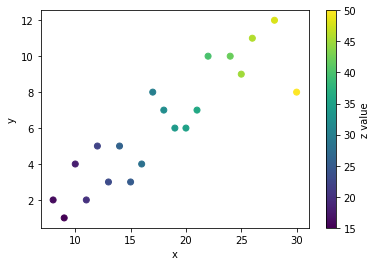

In [28]:
x = [15, 12, 8, 20, 10, 30, 18, 22, 25, 14, 16, 21, 19, 17, 13, 11, 9, 24, 28, 26]
y = [3, 5, 2, 6, 4, 8, 7, 10, 9, 5, 4, 7, 6, 8, 3, 2, 1, 10, 12, 11]
z = [25, 22, 16, 35, 18, 50, 32, 40, 45, 26, 28, 36, 34, 30, 23, 20, 15, 42, 48, 46]

plt.scatter(x, y, c=z)
plt.colorbar(label='z value')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

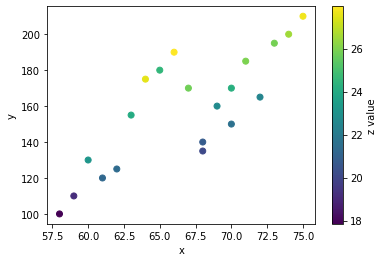

In [25]:
x = np.array([65, 72, 68, 60, 75, 62, 70, 64, 66, 63, 61, 59, 71, 67, 69, 74, 68, 58, 73, 70])
y = np.array([180, 165, 140, 130, 210, 125, 150, 175, 190, 155, 120, 110, 185, 170, 160, 200, 135, 100, 195, 170])
z = np.array([24.49, 22.46, 20.76, 23.17, 27.76, 21.34, 21.60, 27.56, 27.96, 24.02, 21.21, 19.15, 25.95, 25.77, 22.68, 26.53, 20.09, 17.85, 25.86, 24.22])

plt.scatter(x, y, c=z)
plt.colorbar(label='z value')
plt.xlabel('x')
plt.ylabel('y')
plt.show()